In [ ]:
## Project: Action Recognition using CNN + LSTM (PyTorch)
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch  # pyright: ignore[reportMissingImports]
import torch.nn as nn  # pyright: ignore[reportMissingImports]
from torch.utils.data import DataLoader  # pyright: ignore[reportMissingImports]
from torch.optim import Adam  # pyright: ignore[reportMissingImports]
import torchvision.models as models  # pyright: ignore[reportMissingImports]
from utilities.data_processing import VideoDataProcessor, VideoDataset
from utilities.model import ActionRecognitionPipeline, describe_frames_after_predict_each_frame
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

In [ ]:
DIRECTORY = r"C:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\dataset\abnormal"
NORMAL_DIRECTORY = r"C:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\dataset\normal"
PATH_VIDEO_TEST = r"C:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\dataset\test\31.mp4"
RULE_PATH =  r"C:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\dataset\rule\entity_rules.txt"




processor = VideoDataProcessor(DIRECTORY, NORMAL_DIRECTORY, frame_size=64, num_frames=40)
selected_classes = processor.selected_classes
Frame_Size = processor.frame_size
print(selected_classes)

In [ ]:
train_df = processor.build_dataframe()
print(train_df.head())

In [ ]:
# Saving original frame without any resizing
from PIL import Image

for class_index, cls in enumerate(selected_classes):
    if cls == "Normal Videos":
        class_path = os.path.join(NORMAL_DIRECTORY, cls)
        videos = os.listdir(class_path)[:30]
    else:
        class_path = os.path.join(DIRECTORY, cls)
        videos = os.listdir(class_path)[:30]
    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = processor.extract_original_frames(video_path, num_frames=40)
        a = frames.shape  

In [ ]:
X_train, X_test, y_train, y_test = processor.load_training_arrays(videos_per_class=30, test_size=0.2, random_state=42)
print("Training:", len(X_train), "Testing:", len(X_test))

In [ ]:
train_dataset = VideoDataset(X_train, y_train)
val_dataset = VideoDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
num_classes = len(selected_classes)
pipeline = ActionRecognitionPipeline(num_classes, device, frame_size=Frame_Size, num_frames=40)
model = pipeline.model

In [ ]:
PATH_MODEL = r"C:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\dataset\model\best_model.pt"
pipeline.train(train_loader, val_loader, epochs=1, save_path=PATH_MODEL)

In [ ]:
pipeline.load(PATH_MODEL)
#pipeline.show_predictions(X_test, y_test, selected_classes, num_samples=5)

In [ ]:
# Run prediction on test video to get frame_indices, frames, frames_original
frame_indices, preds, probs, frames, frames_original = pipeline.predict_each_frame(
    PATH_VIDEO_TEST, processor, selected_classes
)

In [21]:
# External API image description (5 LLM models: OpenAI, Anthropic, Google)
import importlib.util
spec = importlib.util.spec_from_file_location("llm_based", "utilities/llm-based.py")
llm_based = importlib.util.module_from_spec(spec)
spec.loader.exec_module(llm_based)

ExternalLLMImageDescriber = llm_based.ExternalLLMImageDescriber
MODEL_NAMES = llm_based.MODEL_NAMES

# Optional: set API keys here or via env (OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY)
describer = ExternalLLMImageDescriber(
    default_model="gemini-3-flash-preview",  # advanced Gemini; or "gemini-2.0-flash", "gpt-4o-mini", etc.
)

# Describe a few predicted frames with the external API (uses frames from cell above)
num_frames_to_describe = 4
show_indices = np.linspace(0, len(frame_indices) - 1, min(num_frames_to_describe, len(frame_indices)), dtype=int)
frames_to_describe = [frames_original[i] if frames_original is not None else frames[i] for i in show_indices]

external_descriptions = []
for i, frame in enumerate(frames_to_describe):
    desc = describer.describe_frame(frame, prompt="Describe this video frame in 2–3 short sentences.")
    external_descriptions.append(desc)
    print(f"Frame {frame_indices[show_indices[i]]} [{describer.default_model}]: {desc}")
    print()

Frame 39 [gemini-3-flash-preview]: This is a completely black image featuring a white logo in the top-left corner. The logo displays the text "Live Leak" inside a rectangular border, with smaller text that reads "POSTED ON" positioned above it.

Frame 125 [gemini-3-flash-preview]: This high-angle security camera frame shows a parking lot at night with several cars parked near a building. A bright spotlight illuminates a central area of the lot, and text at the bottom identifies the footage as originating from the South Wales Police.

Frame 212 [gemini-3-flash-preview]: This CCTV frame shows a reception area where two people are working behind a long counter with computers. In the background, there is a small waiting area with sofas and a person walking toward the entrance.

Frame 299 [gemini-3-flash-preview]: This security camera image shows a man standing at a long service counter in what appears to be a reception area. Two staff members are working behind the desk, which is equipped 

Image,Description
,"Frame 39This is a completely black image featuring a white logo in the top-left corner. The logo displays the text ""Live Leak"" inside a rectangular border, with smaller text that reads ""POSTED ON"" positioned above it."
,"Frame 125This high-angle security camera frame shows a parking lot at night with several cars parked near a building. A bright spotlight illuminates a central area of the lot, and text at the bottom identifies the footage as originating from the South Wales Police."
,"Frame 212This CCTV frame shows a reception area where two people are working behind a long counter with computers. In the background, there is a small waiting area with sofas and a person walking toward the entrance."
,"Frame 299This security camera image shows a man standing at a long service counter in what appears to be a reception area. Two staff members are working behind the desk, which is equipped with computer monitors and various office supplies. The frame includes text overlays identifying it as police footage from June 2015."

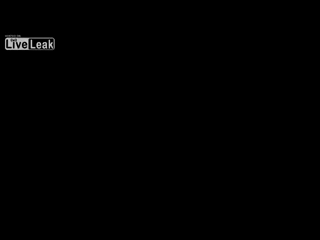
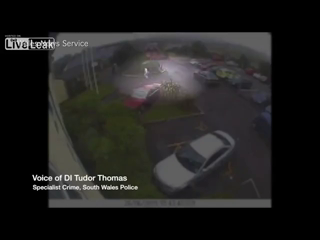
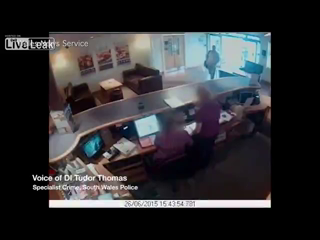
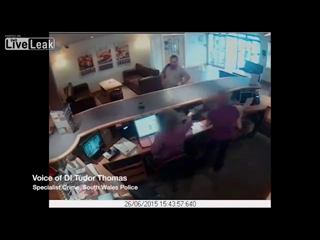

In [22]:
# Display each described frame and its description in a two-column table
import base64
import io
from IPython.display import display, HTML

def frame_to_base64(frame, max_width=320):
    """Convert numpy frame to base64 PNG; optionally scale for display."""
    if frame is None:
        return None
    # Frames from processor are RGB float32 [0,1]; convert to uint8 for PIL
    if frame.dtype == np.float32 or frame.dtype == np.float64:
        frame = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
    elif len(frame.shape) == 3 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # if BGR from cv2
    h, w = frame.shape[:2]
    if max_width and w > max_width:
        scale = max_width / w
        new_w, new_h = max_width, int(h * scale)
        frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)
    pil_img = Image.fromarray(frame.astype(np.uint8))
    buf = io.BytesIO()
    pil_img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

rows = []
for i, (frame, desc) in enumerate(zip(frames_to_describe, external_descriptions)):
    b64 = frame_to_base64(frame)
    if b64 is None:
        img_html = "<em>No image</em>"
    else:
        img_html = f'<img src="data:image/png;base64,{b64}" style="max-width:320px; height:auto;" />'
    frame_idx = frame_indices[show_indices[i]] if i < len(show_indices) else i
    rows.append(f"<tr><td style='vertical-align:top; padding:8px;'>{img_html}</td><td style='vertical-align:top; padding:8px; max-width:400px;'><strong>Frame {frame_idx}</strong><br/><br/>{desc}</td></tr>")

table_html = (
    "<table style='border-collapse: collapse;'>"
    "<thead><tr><th style='text-align:left; padding:8px;'>Image</th><th style='text-align:left; padding:8px;'>Description</th></tr></thead>"
    "<tbody>" + "".join(rows) + "</tbody></table>"
)
display(HTML(table_html))

In [23]:
# Custom entity extraction on frame descriptions (regex + keywords)
from utilities.custom_entity_extractor import load_rules_from_file

# Load rules from external file (entity_rules.txt)
custom = load_rules_from_file(RULE_PATH, merge_overlaps=True)

custom_entities_per_frame = custom.extract_batch(external_descriptions, merge_duplicates=True)

print("Custom entities per frame description (ACTION / OBJECT / SCENE):")
for i, (desc, entities) in enumerate(zip(external_descriptions, custom_entities_per_frame)):
    #short = desc[:80] + ("..." if len(desc) > 80 else "")
    print(f"\nFrame {i}: {desc}")
    if entities:
        print(f"  -> {[str(e) for e in entities]}")
    else:
        print("  -> (none)")

Custom entities per frame description (ACTION / OBJECT / SCENE):

Frame 0: This is a completely black image featuring a white logo in the top-left corner. The logo displays the text "Live Leak" inside a rectangular border, with smaller text that reads "POSTED ON" positioned above it.
  -> (none)

Frame 1: This high-angle security camera frame shows a parking lot at night with several cars parked near a building. A bright spotlight illuminates a central area of the lot, and text at the bottom identifies the footage as originating from the South Wales Police.
  -> ['parking (SCENE)', 'car (OBJECT)', 'building (OBJECT)']

Frame 2: This CCTV frame shows a reception area where two people are working behind a long counter with computers. In the background, there is a small waiting area with sofas and a person walking toward the entrance.
  -> ['people (OBJECT)', 'person (OBJECT)', 'walking (ACTION)']

Frame 3: This security camera image shows a man standing at a long service counter in what 